In [48]:
# Matt London
# P4 - Advanced Lane Finding

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

"""
Design Plan:

1) Compute camera calibration matrix and distortion coeff given a set of chessboard images
2) Apply distortion correction to raw images
3) Use color transforms, gradients, etc., to create a thresholded binary img
4) Apply perspective transform to rectify binary image (birds eye view)
5) Detect lane pixels and fit to find the lane boundary (try to use np.convolve)
6) Determine the curvature of the lane and vehicle position with respect to center
7) Warp the detected lane boundaries back onto the original image
8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
"""

'\nDesign Plan:\n\n1) Compute camera calibration matrix and distortion coeff given a set of chessboard images\n2) Apply distortion correction to raw images\n3) Use color transforms, gradients, etc., to create a thresholded binary img\n4) Apply perspective transform to rectify binary image (birds eye view)\n5) Detect lane pixels and fit to find the lane boundary (try to use np.convolve)\n6) Determine the curvature of the lane and vehicle position with respect to center\n7) Warp the detected lane boundaries back onto the original image\n8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position\n'

# Define functions to be used throughout project

In [49]:
def loadImage(fname):
    """
    Using mpimg.imread(filename)
    This produces an RGB image (as opposed to a BGR image)
    """
    # cv2.imread is BGR
    img = mpimg.imread(fname)
    return img

def calibrateLens(nx, ny, folder):
    #prepare object points, like (0,0,0,), (1,0,0), (2,0,0)...
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store obj points and img points from all images
    objpoints = []
    imgpoints = []

    images = glob.glob(folder+'/calibration*.jpg')
    print("Reading in images. ")

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # write_name = 'corners_found'+str(idx)+'.jpg'
            # cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)
        print("Image {}...\n".format(idx))
    cv2.destroyAllWindows()

    # Test undistortion on an image
    img = cv2.imread(folder+'/calibration5.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    print("Creating undistortion matrix.")

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(folder+'/undistorted/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    print("Creating dist_pickle.p")
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist

    pickle.dump( dist_pickle, open( folder+"/dist_pickle.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    return 

def undistortImage(img, mtx, dist):
    """
    Removes Lens distortion from RAW image. 
    Returns undistorted image
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F,0,1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F,0,1, ksize=sobel_kernel)
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    grad_dir = np.arctan2(absy, absx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

def showImages(img1, img2,title1='Original', title2='Modified', testing=False):
    if testing == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img1,cmap='gray')
        ax1.set_title(title1, fontsize=50)
        ax2.imshow(img2, cmap='gray')
        ax2.set_title(title2, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    return

def show4images(img1,img2,img3,img4,title1='Original',title2='img2',title3='img3',title4='img4', testing=False):
    if testing == True:
        f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img1,cmap='gray')
        ax1.set_title(title1, fontsize=50)
        ax2.imshow(img2, cmap='gray')
        ax2.set_title(title2, fontsize=50)
        ax3.imshow(img3,cmap='gray')
        ax3.set_title(title3, fontsize=50)
        ax4.imshow(img4, cmap='gray')
        ax4.set_title(title4, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    return

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates for realsense img
    xmax = img.shape[1]
    ymax = img.shape[0]
    offset = 200
    
    d_top_left = [250,0]
    d_top_right = [950,0]
    d_bottom_right = [950,720]
    d_bottom_left = [250,720]
    
    top_right = [714,465]
    bottom_right = [1048,676]
    bottom_left = [271,683]
    top_left = [573,466]
    
    src = np.float32(
        [top_right,  # top right
        bottom_right,        # bottom right
        bottom_left,        # bottom left
        top_left])       # top left
    dst = np.float32(
        [[d_top_right],  # top right
        [d_bottom_right],        # bottom right
        [d_bottom_left],        # bottom left
        [d_top_left]])       # top left

    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, Minv

def generate_binary_img(image, ksize = 7):
#     image = cv2.cvtColor(color_img,cv2.COLOR_RGB2GRAY)

    # Choose a Sobel kernel size
    # ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

def mask(img):
    # Masking Region of interest
#     region_of_interest = np.array([[[580,436],[700,436],[1200,720],[150,720]]], np.int32)
    region_of_interest = np.array([[[560,445],[716,445],[1280,720],[150,720]]], np.int32)

    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, region_of_interest, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def start_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.uint8(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print("left_fit shape: {}".format(left_fit.shape))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     print("left_fit: {}".format(left_fit[0]))

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx

# delete
past_frames_left = []

def continue_sliding_window(binary_warped, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     print("left_fit: {}".format(left_fit))
    past_frames_left.append(left_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fitx, right_fitx, ploty, leftx, rightx, left_fit, right_fit

# Load camera calibration data

In [50]:
try:
    folder = "camera_cal"
    # Import pickle with calibrated distortion matrix
    dist_pickle = pickle.load( open( folder+"/dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    print(folder+" Pickle data loaded successfully")
except:
    # Create new pickle data based on camera calibration and distortion matricies
    calibrateLens(9,6,folder)

camera_cal Pickle data loaded successfully


# Load test Image to experiment with

In [51]:
testImg = loadImage("test_images/test2.jpg")
gray = cv2.cvtColor(testImg, cv2.COLOR_RGB2GRAY)
warped, Minv = warp(gray)
binary_img = generate_binary_img(gray, ksize=7)
binary_warp = generate_binary_img(warped, ksize=7)
warped_binary, Minv = warp(binary_img)

showImages(testImg, binary_img,str("testImg"),str('binary_img'))
showImages(warped, warped_binary,str("Warped Image"),str("Warped Binary"))

# Show image mask

In [52]:
masked = mask(testImg)
showImages(testImg, masked)
testImg.shape

(720, 1280, 3)

# Visualize test images in various color spaces

In [53]:
def hls_select(image, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]    
    # 2) Apply a threshold to the S channel
    
    S_binary = np.zeros_like(S)
    L_binary = np.zeros_like(S)
    S_binary[(S> thresh[0]) & (S <= thresh[1])] = 1
    L_binary[(L> thresh[0]) & (L <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    show4images(image,H,L,S,"Original", 'H','L','S')
    return S_binary, L_binary, S, L

S_binary, L_binary, S , L = hls_select(testImg, thresh=(150, 255))
showImages(S_binary, L_binary,"S binary", "L binary")

In [54]:
def rgb_select(image, thresh=(200,255)):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
#     show4images(image,R,G,B,"Original", 'R','G','B')
    return binary, R

r_binary , R = rgb_select(testImg, thresh=(200,255))
showImages(testImg, r_binary, "Test Image", "(R)GB Binary")

In [55]:
def hsv_select(image, thresh=(160,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hls[:,:,0]
    S = hls[:,:,1]
    V = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(V > thresh[0]) & (V <= thresh[1])] = 1
#     show4images(image,H,S,V,"Original", 'H','S','V')
    return binary

hsv_binary = hsv_select(testImg)
showImages(testImg, hsv_binary, 'Test Image', 'HS(V) Binary')

In [56]:
def gray_select(img, thresh=(180,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary
gray_binary = gray_select(testImg, thresh=(180,255))
showImages(testImg, gray_binary, 'Test Image', 'Gray Binary')

# YCrCb testing

In [57]:
def Ycrcb_select(image, thresh=(150,255)):
    YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = YCrCb[:,:,0]
    Cr = YCrCb[:,:,1]
    Cb = YCrCb[:,:,2]
    binary = np.zeros_like(Y)
    binary[(Y > thresh[0]) & (Y <= thresh[1])] = 1
    show4images(image,Y,Cr,Cb,"Original", 'Y','Cr','Cb')
    return binary

ycrcb_binary = Ycrcb_select(testImg)
showImages(testImg, ycrcb_binary, 'Test Image', 'YCrCb Binary')

# RGB threshold testing

In [58]:
ksize = 5
gray = cv2.cvtColor(testImg,cv2.COLOR_RGB2GRAY)
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(35, 110))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.7,1.3 ))

test_combined = np.zeros_like(dir_binary)
test_combined[((gradx == 1)) & (grady == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

show4images(gradx,grady,mag_binary, dir_binary, 'gradx','grady','mag_binary',"dir_binary")
showImages(gray,test_combined,'gradx', "combined")

# Red threshold testing

In [59]:
def gen_R_binary(R,ksize=5, testing=False):
    # ksize = 5
    gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(R, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(35, 110))
    dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(.7,1.3 ))

    r_combined = np.zeros_like(dir_binary)
    r_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if testing == True:
        show4images(gradx,grady,mag_binary, dir_binary, 'gradx','grady','mag_binary',"dir_binary")
    
    return r_combined
r_combined = gen_R_binary(R, testing=True)
showImages(R,r_combined,'gradx', "R combined")

# S Threshold Testing

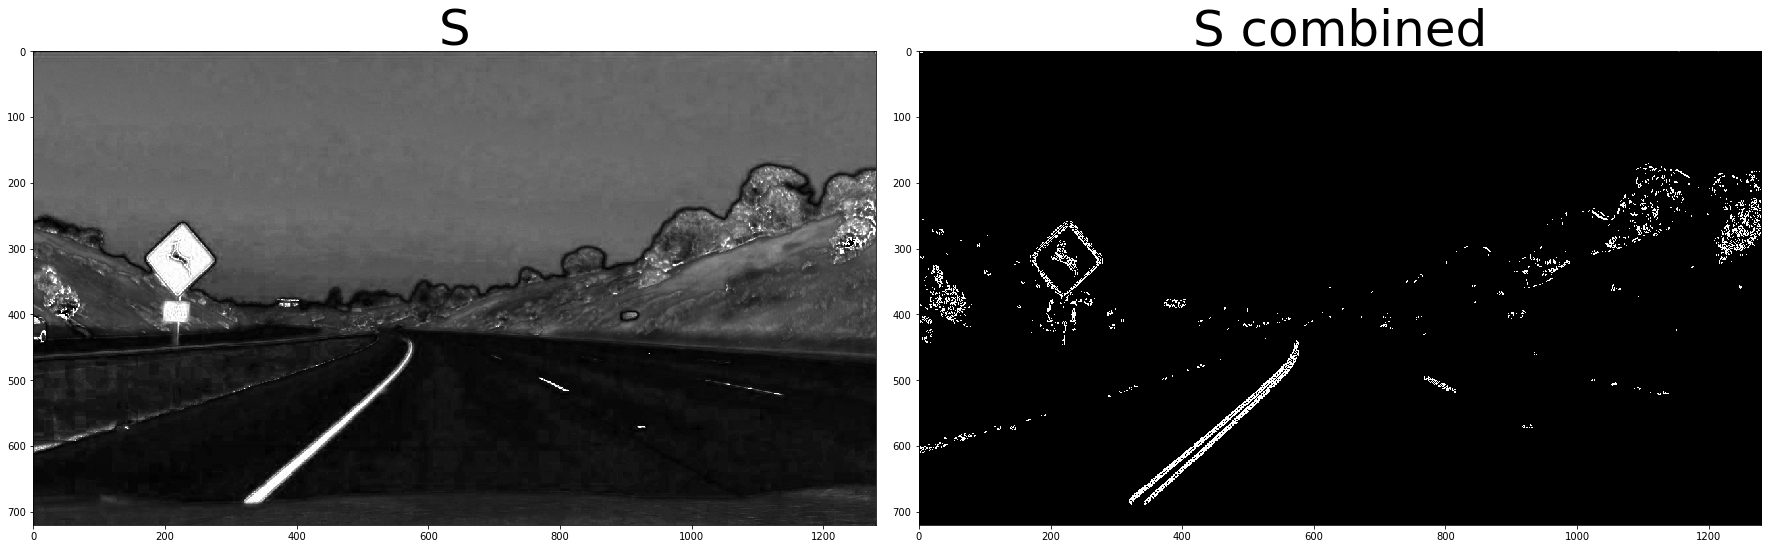

In [79]:
def gen_S_binary(S,ksize=7, testing=False):
    # ksize = 7
    gradx = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(40, 100))
    grady = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(40, 100))
    mag_binary = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(50, 100))
    dir_binary = dir_threshold(S, sobel_kernel=ksize, thresh=(.7,1.3 ))

    S_combined = np.zeros_like(dir_binary)
    S_combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if testing == True:
        show4images(gradx,grady,mag_binary, dir_binary, 'gradx','grady','mag_binary',"dir_binary")

    return S, S_combined
S, S_combined = gen_S_binary(S,testing=True)
showImages(S,S_combined,'S', "S combined", testing=True)

# Luminance Threshold Testing

In [61]:
def gen_L_binary(L, ksize=7, testing=False):
#     ksize = 7
    gradx = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(L, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(L, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(L, sobel_kernel=ksize, thresh=(.7,1.3 ))

    L_combined = np.zeros_like(dir_binary)
    L_combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if testing == True:
        show4images(gradx,grady,mag_binary, dir_binary, 'gradx','grady','mag_binary',"dir_binary")
        
    return L_combined
L_combined = gen_L_binary(L, testing=False)
showImages(L,L_combined,'S', "combined L")

In [62]:
binary_r = generate_binary_img(R)
binary_s = generate_binary_img(S)
showImages(R, binary_r, 'binary red', 'binary S')

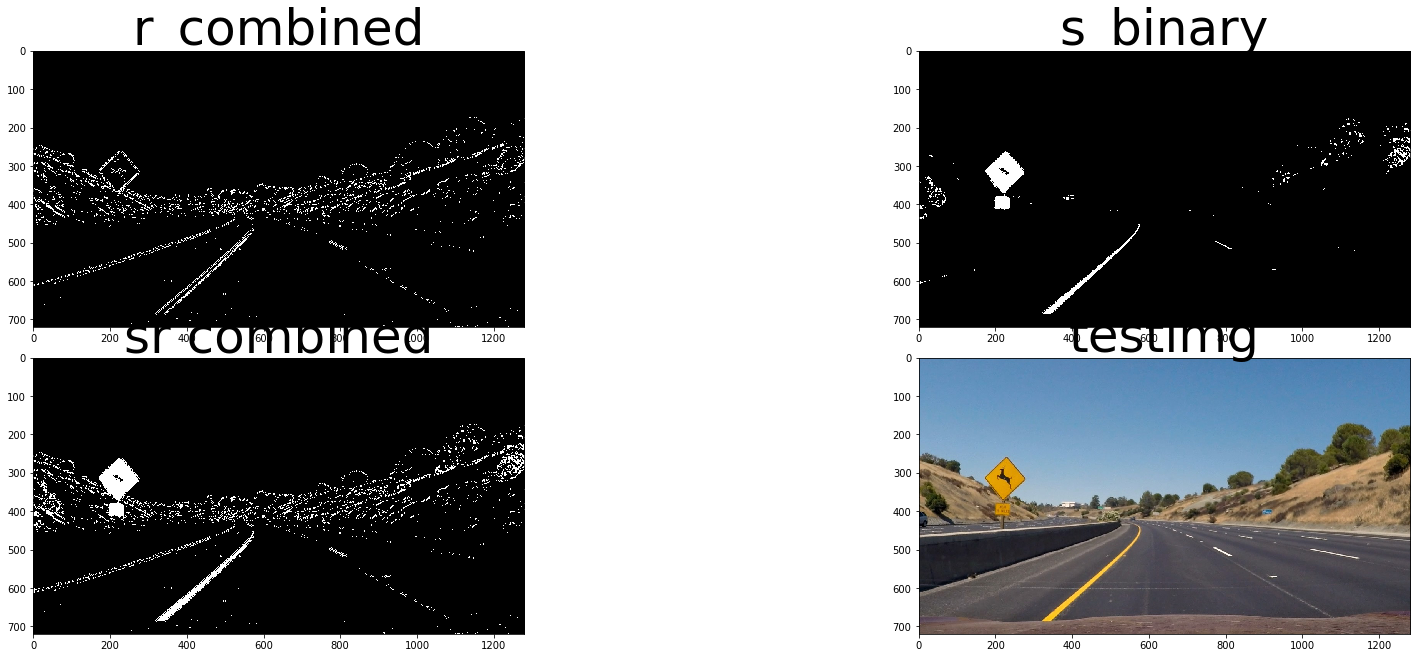

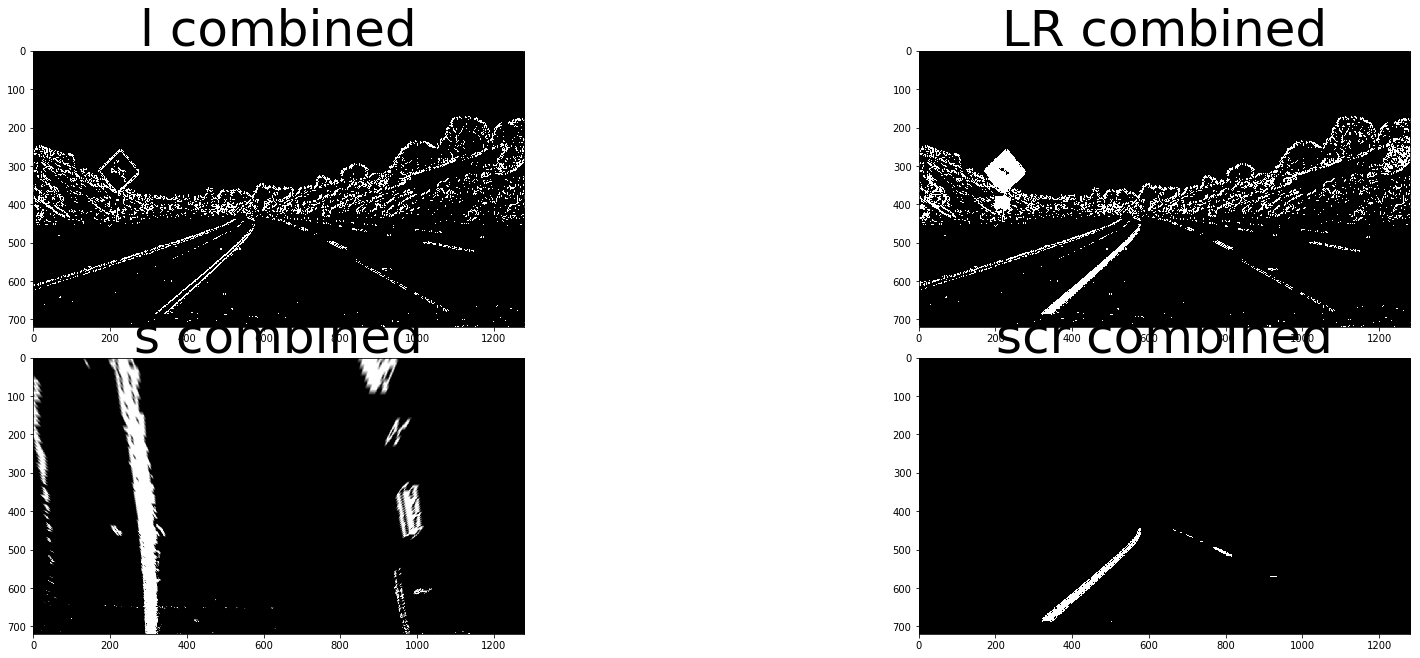

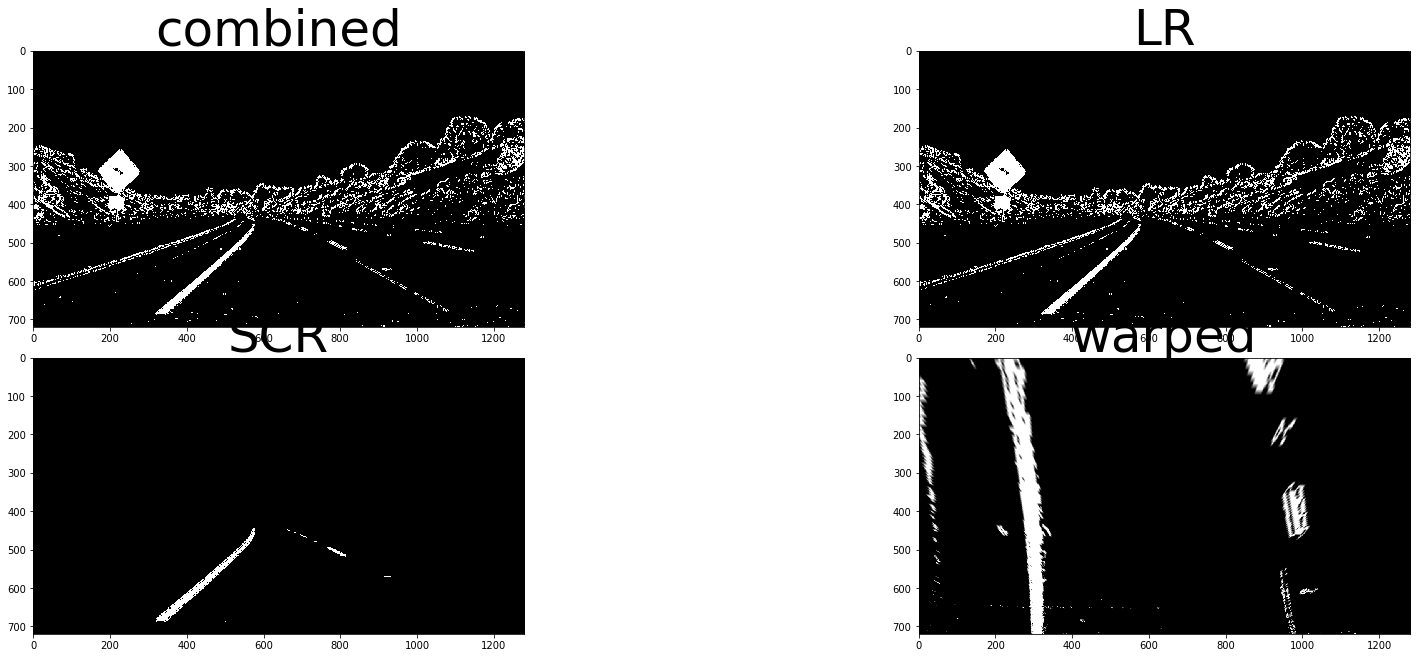

In [77]:
def combine_binary(img1, img2, flag='OR'):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(img1)
    if flag == 'AND':
        combined_binary[(img1 == 1) & (img2 == 1)] = 1
    else:
        combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

# LR_combined = combine_binary(rgb_binary, L_binary, flag='AND')
# combined = combine_binary(LR_combined,S_combined,flag='OR')

Sr_combined = combine_binary(r_combined,S_binary)
LR_combined = combine_binary(Sr_combined,L_combined)
SCr_combined = mask(combine_binary(S_combined, ycrcb_binary))
combined = combine_binary(LR_combined,SCr_combined)
# showImages(binary_r,combined)
LR_warped, Minv = warp(LR_combined)
warped, Minv = warp(combined)
# showImages(mask(combined), warped)
# show4images(r_combined, r_binary, Sr_combined, LR_combined,'r_combined', 'r_binary', 'rr_combined', 'LR_combined')
# show4images(L_combined, ycrcb_binary, S_binary, warped,'L combined', 'ycrcb binary', 'S_binary', 'warped')
show4images(r_combined, S_binary, Sr_combined, testImg, 'r_combined', 's_binary', "sr combined", "testimg", testing=True)
show4images(L_combined, LR_combined, LR_warped, SCr_combined, 'l combined', 'LR combined', 's combined', 'scr combined', testing=True)
show4images(combined, LR_combined, SCr_combined, warped, 'combined', 'LR', 'SCR', 'warped', testing=True)

# Find lane lines

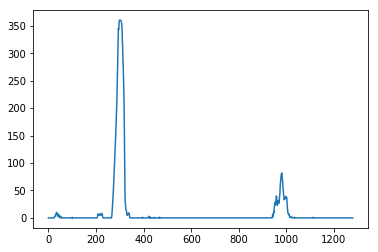

In [64]:
img = warped.astype(np.uint8)
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

# Use sliding window algorithm to locate lane lines

In [ ]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = start_sliding_window(warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Using the sliding windows we just created...

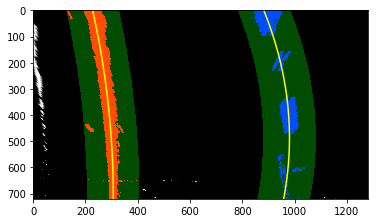

In [66]:
result, left_fitx, right_fitx, ploty, leftx, rightx, left_fit, right_fit = continue_sliding_window(warped, left_fit, right_fit)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Measuring Curvature

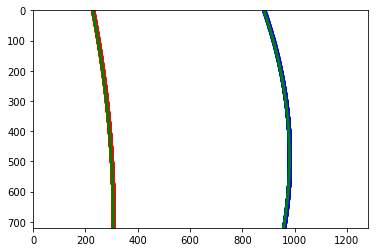

3212.57114644 1280.93432044


In [67]:
# # Generate some fake data to represent lane-line pixels
# # ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(left_fitx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(right_fitx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [68]:
def calc_curve(ploty, left_fitx, right_fitx, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

left_curverad, right_curverad = calc_curve(ploty, left_fitx, right_fitx, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1055.17118004 m 399.168418762 m


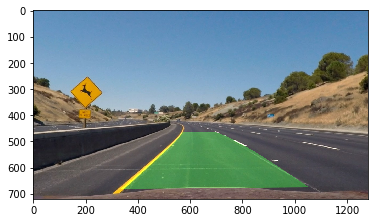

In [69]:
def project_lane(img, mtx, dist, warped, left_fitx, right_fitx, ploty):
    undist = undistortImage(img, mtx, dist)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
result = project_lane(testImg, mtx, dist, warped, left_fitx, right_fitx, ploty)
plt.imshow(result)
plt.show()

# Line class to hold old information

In [72]:
class VideoProcessor(object):

    # constructor function
    def __init__(self):
        # values of the last n fits of the line
        self.past_frames_left = []
        self.past_frames_right = []

        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = np.array([])
        self.best_fit_right = np.array([])

        self.first_frame = True

        self.mtx = np.array([])
        self.dist = np.array([])

    def moving_average_curvature(self):
        sum = 0
        N = len(self.past_frames_left)
        if N > 40:
            self.past_frames_left.pop(0)
            self.past_frames_right.pop(0)
            N = len(self.past_frames_left)

        l_coeff2 = 0
        l_coeff1 = 0
        l_coeff0 = 0

        r_coeff2 = 0
        r_coeff1 = 0
        r_coeff0 = 0

        for i in range(0,len(self.past_frames_left)):
#             print(self.past_frames_left)
#             # print(self.past_frames_left.shape)
#             print(i)
            l_coeff2 += self.past_frames_left[i][0]
            l_coeff1 += self.past_frames_left[i][1]
            l_coeff0 += self.past_frames_left[i][2]

            r_coeff2 += self.past_frames_right[i][0]
            r_coeff1 += self.past_frames_right[i][1]
            r_coeff0 += self.past_frames_right[i][2]

        # for i in self.past_frames_right:

        #     r_coeff2 += self.past_frames_right[i][0]
        #     r_coeff1 += self.past_frames_right[i][1]
        #     r_coeff0 += self.past_frames_right[i][2]

        l_coeff2 = l_coeff2 / N
        l_coeff1 = l_coeff1 / N
        l_coeff0 = l_coeff0 / N

        r_coeff2 = r_coeff2 / N
        r_coeff1 = r_coeff1 / N
        r_coeff0 = r_coeff0 / N


        self.best_fit_left = np.array([l_coeff2, l_coeff1, l_coeff0])
        self.best_fit_right = np.array([r_coeff2, r_coeff1, r_coeff0])

        return self.best_fit_left, self.best_fit_right

    def process_frame(self, frame):
        # your lane detection pipeline

        try:
            if self.first_frame == True:
                folder = "camera_cal"
                # Import pickle with calibrated distortion matrix
                dist_pickle = pickle.load( open( folder+"/dist_pickle.p", "rb"))
                self.mtx = dist_pickle["mtx"]
                self.dist = dist_pickle["dist"]
                print(folder+" Pickle data loaded successfully")
        except:
            # Create new pickle data based on camera calibration and distortion matricies
            calibrateLens(9,6,folder)
            print('Exception - calibrating lens')

        S_binary, L_binary, S , L = hls_select(frame, thresh=(100, 255))
        L_combined = gen_L_binary(L)
        rgb_binary , R = rgb_select(frame, thresh=(200,255))
        r_combined = generate_binary_img(R)
        LR_combined = combine_binary(r_combined, L_combined)
        binary_s = generate_binary_img(S)
        combined = combine_binary(LR_combined, binary_s)
        warped, Minv = warp(combined)
        warped = warped.astype(np.uint8)
        
        if self.first_frame == True:
            out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = start_sliding_window(warped)

            # Update object attributes
            self.first_frame = False
            self.past_frames_left.append(left_fit)
            self.past_frames_right.append(right_fit)
            self.best_fit_left = left_fit
            self.best_fit_right = right_fit

            print('first frame')
        else:
            result, left_fitx, right_fitx, ploty, leftx, rightx, left_fit, right_fit = continue_sliding_window(warped, self.best_fit_left, self.best_fit_right)
            
            self.past_frames_left.append(left_fit)
            self.past_frames_right.append(right_fit)
            # self.past_frames_left = left_fit
            # self.past_frames_right = right_fit
            self.best_fit_left, self.best_fit_right = self.moving_average_curvature()

        ### Calculate curvature
        left_curverad, right_curverad = calc_curve(ploty, left_fitx, right_fitx, self.best_fit_left, self.best_fit_right)
        result = project_lane(frame, self.mtx, self.dist, warped, left_fitx, right_fitx, ploty)
        return result

## Video Processing

In [73]:
VideoProcessor = VideoProcessor()
white_output = 'output_images/full_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(VideoProcessor.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

camera_cal Pickle data loaded successfully
first frame
[MoviePy] >>>> Building video output_images/full_output.mp4
[MoviePy] Writing video output_images/full_output.mp4



100%|█████████▉| 1260/1261 [10:29<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/full_output.mp4 

CPU times: user 9min 36s, sys: 2min 15s, total: 11min 52s
Wall time: 10min 30s
